In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

import matplotlib
#from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time
import pickle
import corner

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

from scipy.integrate import quad
def integral(x): 
    return np.sqrt(1-v**2) * 1/(1-v*np.cos(x))*np.sin(x)*np.cos(x)**2 * (3) 

#n_days = np.array([126000, 212400, 298800, 385200])/86400
#n_days = np.array([1.43, 2.42, 3.41, 4.4])
#n_days = np.array([1.43, 2.42, 3.45, 4.4, 5.4])

#beta, doppler = np.loadtxt('doppler_wo_prolate.txt')
#inter = interp1d(beta, doppler)

#beta1, doppler1 = np.loadtxt('doppler_wo_prolate_inv.txt')
#inter = interp1d(beta1, doppler1)

beta1, doppler1 = np.loadtxt('../doppler_with_cossin.txt')
inter = interp1d(beta1, doppler1)
inter2 = inter

#beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv.txt')
#inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    #delta = (1-vphot**2)**(1/2) * 1/(1-vphot)
    #delta = (1-vphot**2)**(-1/2) * (1-vphot)
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**2#**4
    #corr = 1.08**2
        
    theta = 2*np.sqrt( N*10**(7) * corr / np.pi ) #inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc


In [18]:
beta, doppler = np.loadtxt('../codes - Diluted BB/Derivation_conv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta#/inter2(vphot)**2#**4
        
    theta = 2*np.sqrt( N*10**(7) / np.pi ) #inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

files = ["../Data/OB1/OB1_3_peaks_with_gaussian_3.pkl", #"./Data/OB1/Inflated_unc_chi1_100x5000.pkl", #"./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", 
         "../data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "../data/OB3/OB3_3_peaks_with_gaussian.pkl", 
         "../Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "../Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.005, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0

n_days = [1.43, 2.42, 3.42, 4.40, 5.40]
mean_dl = []
vphot_mean = []
temp = []
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
    
    mean_dl.append(np.mean(dl))
    print(np.mean(vphot))
    
    vphot_mean.append(np.mean(vphot))
    temp.append(emcee_res.params['T'].value)
vphot_mean = np.array(vphot_mean)

0.27785912217275427
0.24757938343545796
0.2040098785933382
0.172492971072059
0.1460883861673466


In [19]:
delta = np.sqrt(1-vphot_mean**2) /(1-vphot_mean)

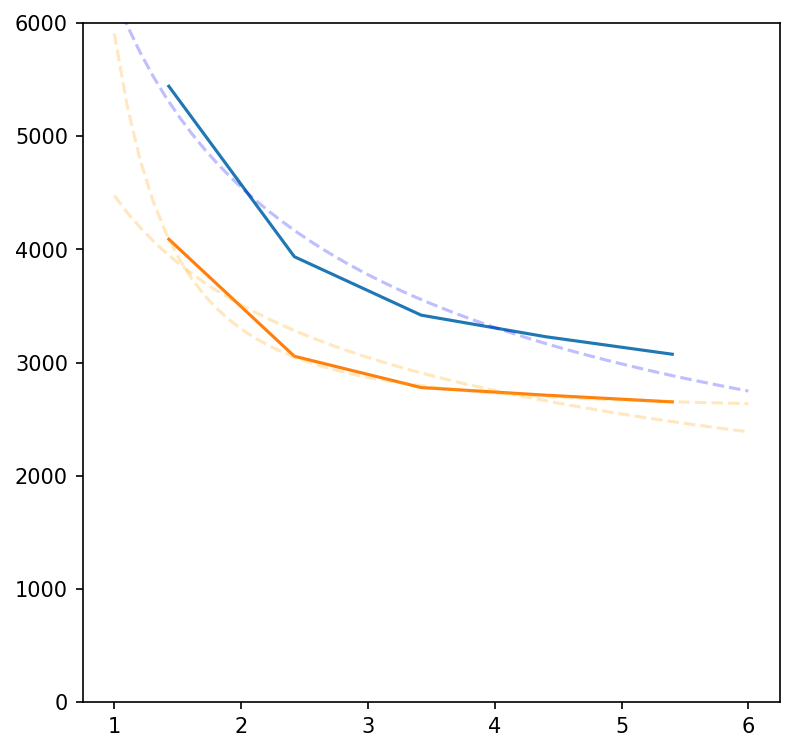

In [25]:
plt.subplots(figsize=(6,6), dpi=150)
plt.plot(n_days, temp)
plt.plot(n_days, temp/delta)
plt.ylim(0, 6000)
plt.plot(np.linspace(1, 6), powerlaw(np.linspace(1, 6), *p), ls='--', color='blue', alpha=0.25)
plt.plot(np.linspace(1, 6), powerlaw(np.linspace(1, 6), *p_d), ls='--', color='orange', alpha=0.25)
plt.plot(np.linspace(1, 6), powerlaw_with_c(np.linspace(1, 6), *p_d_1), ls='--', color='orange', alpha=0.25)

In [ ]:
temp/delta

In [ ]:
delta = (inter2(vphot_mean))
delta

(array([-4.58164539e-01,  6.24877022e+03]),
 array([-3.50082556e-01,  4.47482090e+03]),
 array([4.89933442e-02, 3.16957741e+02]))

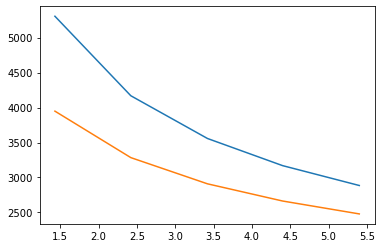

In [23]:
def powerlaw(x, a, b): 
    return b*x**(a)

from scipy.optimize import curve_fit
p,cov = curve_fit(powerlaw, n_days, temp, p0 = [-0.5, 10000])

plt.plot(n_days, powerlaw(n_days, *p))

p_d,_ = curve_fit(powerlaw, n_days, temp/delta, p0 = [-0.5, 10000])

plt.plot(n_days, powerlaw(n_days, *p_d))
p, p_d, np.sqrt(np.diagonal(cov))

array([-2.20173760e+00,  3.33402591e+03,  2.57378808e+03])

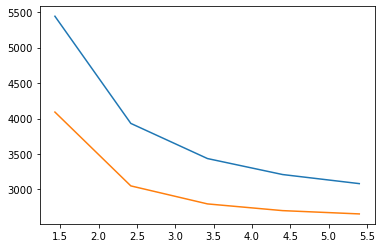

In [24]:
def powerlaw_with_c(x, a, b, c): 
    return b*x**(a) + c

from scipy.optimize import curve_fit
p_1,_ = curve_fit(powerlaw_with_c, n_days, temp, p0 = [-0.5, 10000, 2500])

plt.plot(n_days, powerlaw_with_c(n_days, *p_1))

p_d_1,_ = curve_fit(powerlaw_with_c, n_days, temp/delta, p0 = [-0.5, 10000, 2500])

plt.plot(n_days, powerlaw_with_c(n_days, *p_d_1))
p_d_1

In [32]:
r = np.array([6.88, 6.36, 6.27, 7.431, 12.25, 16.78, 15.93])*1e12
beta = r/(24*3600*np.array(time)*c)
doppler = (1-beta**2)/(1-beta)
doppler

array([1.41603777, 1.35254364, 1.23417052, 1.20090386, 1.19553497,
       1.18967962, 1.13958286])

In [33]:
#moving at 40 percent the speed of light in our referenceframe
6.878*1e14/(c*0.68*24*3600) #/ ((1-0.4**2)**(1/2))

39.0227850399419

In [52]:
time = [0.638, 0.696, 1.033, 1.427, 2.417, 3.413, 4.403]
Temp = [7600, 7500, 7300, 5950, 3800, 3000, 2900]
dTemp = [2000, 1800, 1500, 500, 300, 200, 150]

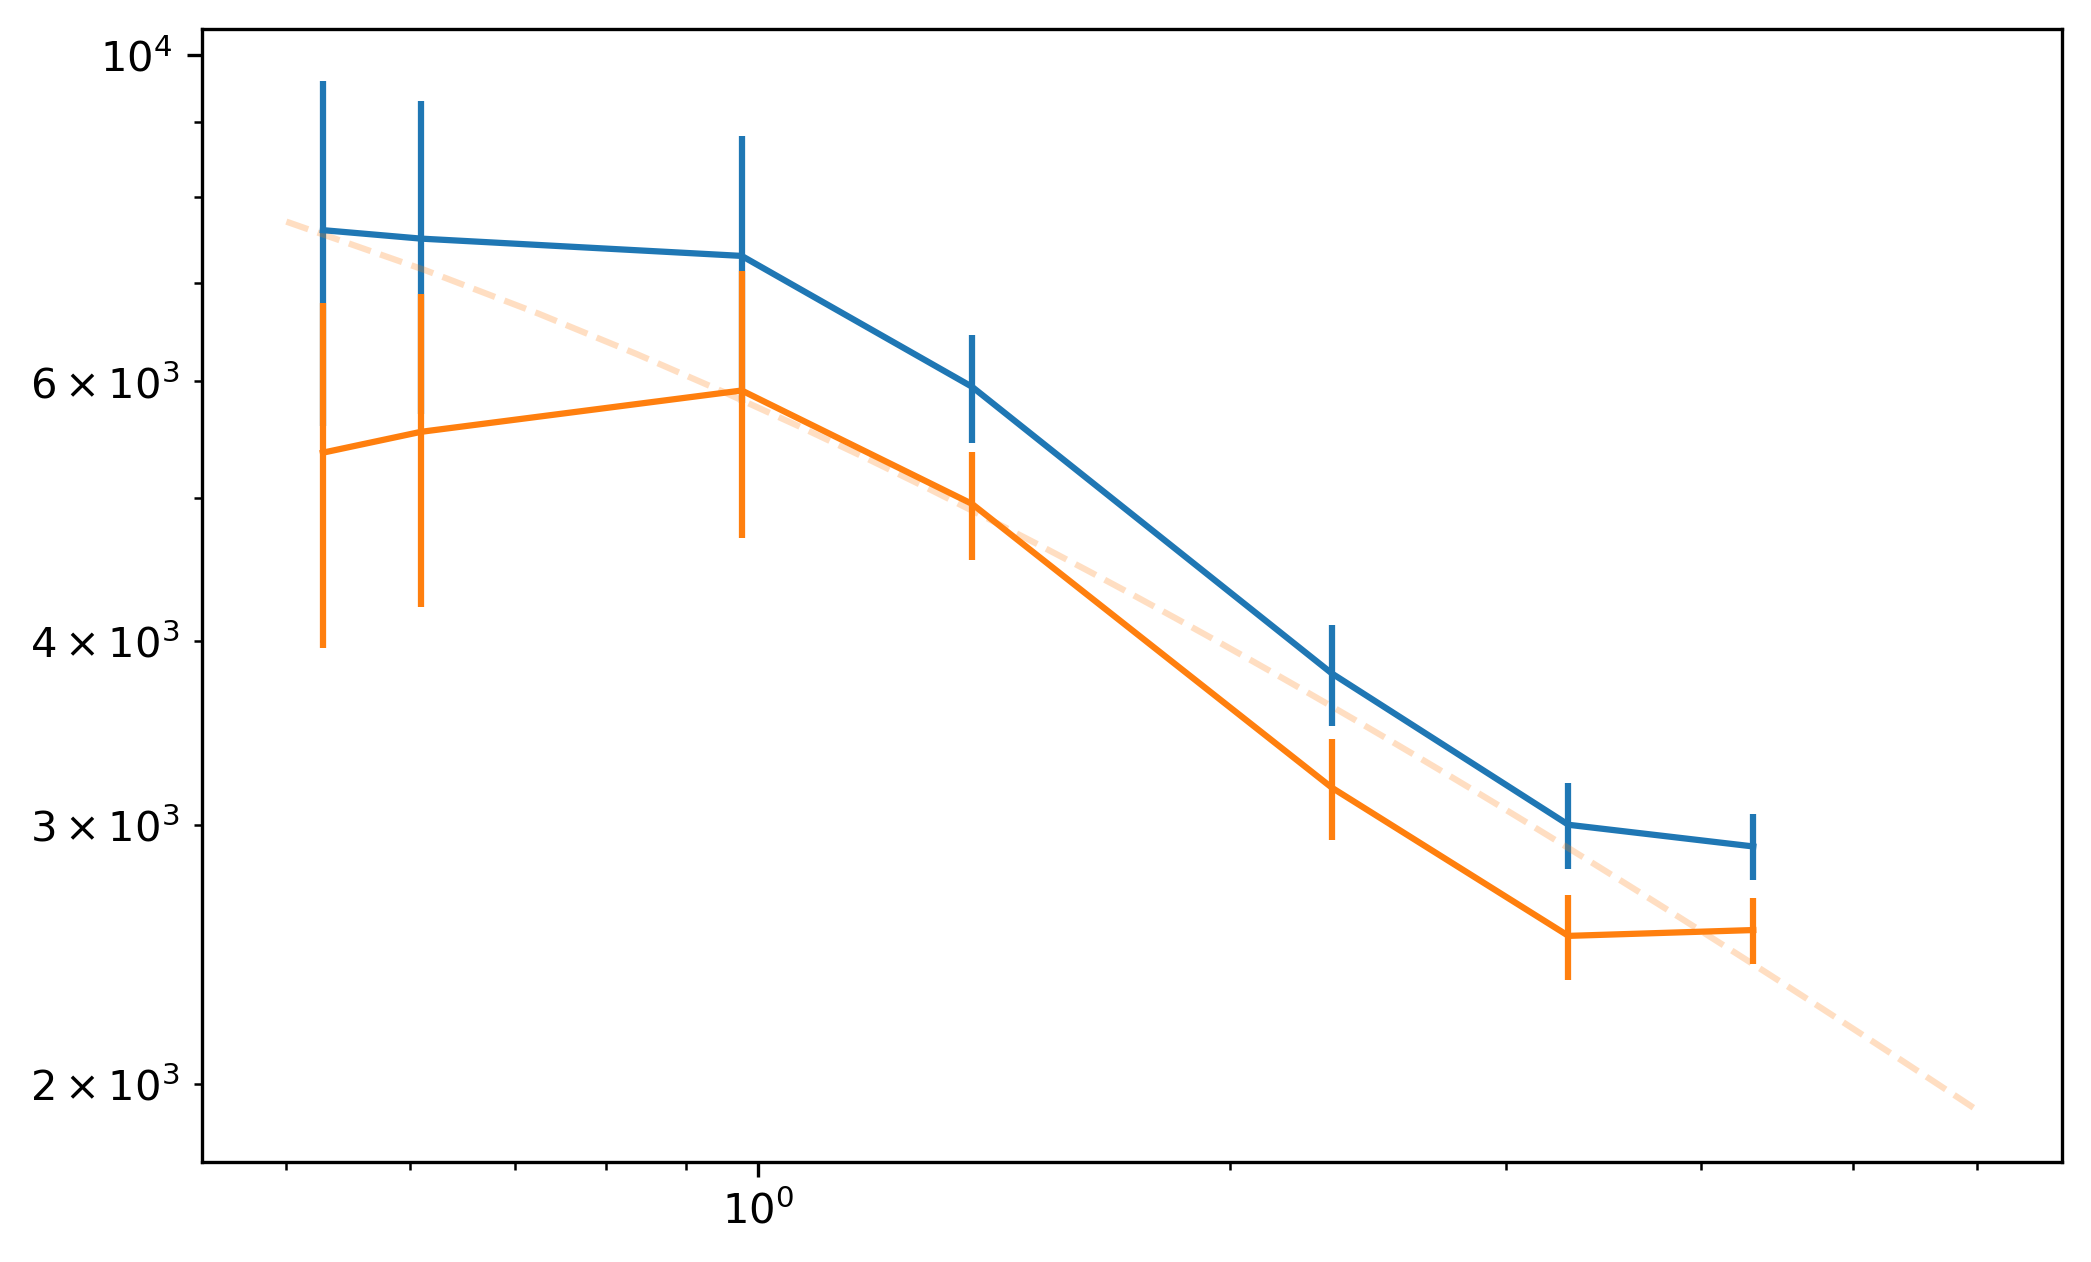

In [55]:
plt.figure(figsize=(8,5), dpi=300)
plt.errorbar(time*(1-beta**2), Temp, yerr=dTemp)
plt.errorbar(time*(1-beta**2), Temp/doppler, yerr=dTemp/doppler)
plt.xscale('log'), plt.yscale('log')
plt.plot(np.linspace(0.5, 6), powerlaw(np.linspace(1, 6), *p), ls='--', color='C1', alpha=0.25)


In [36]:
np.array(time)

array([0.638, 0.696, 1.033, 1.427, 2.417, 3.413, 4.403])

In [51]:
p,cov = curve_fit(powerlaw, time[2:-1], Temp[2:-1], p0 = [-0.5, 10000], sigma=dTemp[2:-1])
p, np.sqrt(np.diagonal(cov))

(array([-7.75301586e-01,  7.70205754e+03]),
 array([3.14165411e-02, 2.26182427e+02]))

In [49]:
p,cov = curve_fit(powerlaw, time, (Temp/doppler), p0 = [-0.5, 10000], sigma=(dTemp/doppler))
p, np.sqrt(np.diagonal(cov))

(array([-5.14956000e-01,  5.19334598e+03]),
 array([7.56062616e-02, 4.60263631e+02]))

In [ ]:
-0.51, 0.07

In [76]:
p_1,cov_1 = curve_fit(powerlaw_with_c,  time, Temp, p0 = [-0.5, 6000, 2500], sigma=dTemp)
p_1, np.sqrt(np.diagonal(cov_1))

(array([-6.94965361e-01,  6.05234678e+03,  6.36455034e+02]),
 array([4.12166421e-01, 2.02105374e+03, 2.07212180e+03]))

In [85]:
p_1,cov_1 = curve_fit(powerlaw_with_c,  time, Temp/doppler, p0 = [-0.5, 6000, 2500], sigma=dTemp/doppler)
p_1, np.sqrt(np.diagonal(cov_1))

(array([-5.54988398e-01,  4.94604298e+03,  2.54144200e+02]),
 array([5.96808117e-01, 3.37661664e+03, 3.45031446e+03]))

In [86]:
p,cov = curve_fit(powerlaw, time, Temp/doppler, p0 = [-0.5, 10000], sigma=dTemp/doppler)
p, np.sqrt(np.diagonal(cov))

(array([-5.14956000e-01,  5.19334598e+03]),
 array([7.56062616e-02, 4.60263631e+02]))

In [61]:
np.array([7.431*1e14,0.465*1e14])/(c*1.427*3600*24) #*(45/40)

array([20.09038646,  1.25716992])